In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58b48000 @  0x7f7166b3b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

In [0]:
#set hyperparameters
epoch = 10
batch_size = 50
learning_rate = 0.005

#download data
cifar_train = dsets.CIFAR10("./data", train=True, transform=transforms.ToTensor(),target_transform = None, download = True)
cifar_test = dsets.CIFAR10("./data", train=False, transform=transforms.ToTensor(),target_transform = None, download = True)

#set Dataloader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,batch_size=batch_size,shuffle=True,num_workers=10)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=batch_size, shuffle=True,num_workers=10)

Files already downloaded and verified


In [0]:
len(cifar_train), len(cifar_test), cifar_train[0][0].size(), cifar_train[0][1]

(50000, 10000, torch.Size([3, 32, 32]), 6)

In [0]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
CLASSES[cifar_train[0][1]]
cuda = torch.cuda.is_available()
print(cuda)

True


In [0]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 3 x 32 x 32 -> batch x 3072
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1=nn.Sequential(
        nn.Conv2d(3,32,3,padding=1), # 32*32*32
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),  # 32*32*64
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,128,3,padding=1), # 32*32*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,128,3,padding=1), # 32*32*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2)   # 16*16*128
        )
        self.layer2=nn.Sequential(
        nn.Conv2d(128,256,3, padding=1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Conv2d(256,256,3, padding=1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2,2)   # 8*8*256
        )
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(batch_size,-1)
        return out
    
if cuda:
    encoder = Encoder().cuda()
else:
    encoder = Encoder()

In [0]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 3072 -> batch x 3 x 32 x 32

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1=nn.Sequential(
        nn.ConvTranspose2d(256,256,3,2,1,1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256,128,3,1,1), # 16*16*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,128,3,1,1), # 16*16*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1), # 16*16*64
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
        
        self.layer2=nn.Sequential(
        nn.ConvTranspose2d(64,32,3,1,1), # 16*16*32
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32,3,3,2,1,1), #32*32*3
        nn.ReLU(),
        nn.BatchNorm2d(3),
        )
    def forward(self,x):
        out=x.view(batch_size,256,8,8)
        out=self.layer1(out)
        out=self.layer2(out)
        return out
if cuda:
    decoder=Decoder().cuda()
else:
    decoder=Decoder()

In [0]:
# train encoder and decoder
# save and load model

def train_autoencoder(loss_func,optimizer):  
    iter = 0
    for i in range(epoch):
        for images,labels in train_loader:
            #Add noise to data
            images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size,3,32,32))
      
            if cuda:
                images=Variable(images).cuda()
                images_n=Variable(images_n).cuda()
                labels = Variable(labels.float()).cuda()
            else:
                images = Variable(images)
                images_n = Variable(images_n)
                labels = Variable(labels.float())
      
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
      
            # Forward pass to get latent representation for CIFAR10
            outputs=encoder(images_n) 
      
            #Exceute the decoder
            outputs=decoder(outputs)
      
            # Calculate Loss: MSEloss
            loss=loss_func(outputs,images)
      
            # Getting gradients w.r.t. parameters
            loss.backward()
      
            # Updating parameters
            optimizer.step()

In [0]:
def execution():
  # loss func and optimizer
  # we compute reconstruction after decoder so use Mean Squared Error
  # In order to use multi parameters with one optimizer,
  # concat parameters after changing into list

  parameters=list(encoder.parameters())+ list(decoder.parameters())
  loss_func=nn.MSELoss()
  optimizer=torch.optim.Adam(parameters, lr= learning_rate)
  train_autoencoder(loss_func,optimizer)

In [0]:
execution()

In [0]:
torch.save(encoder.state_dict(), "encoder.th")
encoder.load_state_dict(torch.load("encoder.th"))
print(encoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05

In [0]:
torch.save(decoder.state_dict(), "decoder.th")
decoder.load_state_dict(torch.load("decoder.th"))
print(decoder)

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1

In [0]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

Input torch.float32


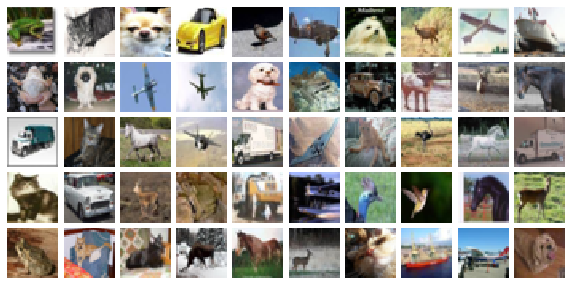

Noisy Input for encoder torch.float32


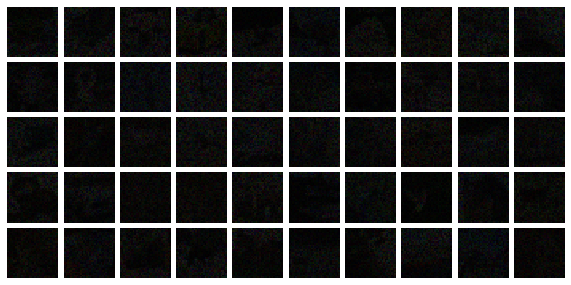

AutoEncoder Output torch.float32


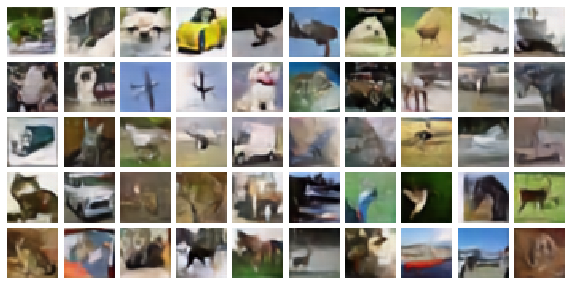

In [0]:
def visualise_img(tensor, num_cols=10):
    num_imgs = tensor.shape[0]
    num_rows = 1+ num_imgs // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_imgs):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i].transpose((1, 2, 0)))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show() 

# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
for images,labels in test_loader:
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size,3,32,32))
    if cuda:
        images=Variable(images).cuda()
        images_n=Variable(images_n).cuda()
    else:
        images = Variable(images)
        images_n = Variable(images_n)
    outputs=encoder(images_n)
    outputs=decoder(outputs)
    if cuda:
        outputs=Variable(outputs).cuda()
    else:
        outputs = Variable(outputs)
    break
  
  
print('Input', images.dtype)
visualise_img(images.detach().cpu().numpy())
print('Noisy Input for encoder', images_n.dtype)
visualise_img(images_n.detach().cpu().numpy())
print('AutoEncoder Output', outputs.dtype)
outputs = min_max_normalization(outputs,0,1)
visualise_img(outputs.detach().cpu().numpy())